In [152]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##### Load and Prep data

In [178]:
root = Path.cwd().parent # find project root
adapt_df = pd.read_csv(os.path.join(root, 'outputs', 'full_sim_n10000_adapt.csv'))
noadapt_df = pd.read_csv(os.path.join(root, 'outputs', 'full_sim_n10000_noadapt.csv'))
# Add adaptation column
adapt_df['adaptation'] = 'Yes'
noadapt_df['adaptation'] = 'No'
# Combine data frames
df = pd.concat([adapt_df, noadapt_df], ignore_index=True)
# Add total cap damage column
df["CAP_dam"] = df[["PRI_dam", "PUB_dam"]].sum(axis=1)
# Baseline PREDICTED RATING 
baseline_rating = 12.42
df["Downgrade"] = baseline_rating - df["predicted_rating"]

##### Start with just baseline investigation

In [179]:
baseline_df = df[
    (df['scenario'] == 'baseline') &
    (df['adaptation'] == 'No')
    ]
future_df = df[
    (df['scenario'] == 'ssp585') &
    (df['epoch'] == 2050) &
    (df['stat'] == 'mean') &
    (df['adaptation'] == 'No')
    ]
adapted_df = df[
    (df['scenario'] == 'ssp585') &
    (df['epoch'] == 2050) &
    (df['stat'] == 'mean') &
    (df['adaptation'] == 'Yes')
    ]

In [180]:
# Sort dataframe by baseline capital stock damages
baseline_sorted = baseline_df.sort_values(by="CAP_dam", ascending=False).reset_index(drop=True)
baseline_sorted["order"] = np.arange(len(baseline_sorted))

In [181]:
future_sorted = (
    future_df
    .merge(baseline_sorted[['year_index', 'order']], on="year_index", how="inner")
    .sort_values("order")
    .drop(columns="order")
    .reset_index(drop=True)
)
adapted_sorted = (
    adapted_df
    .merge(baseline_sorted[['year_index', 'order']], on="year_index", how="inner")
    .sort_values("order")
    .drop(columns="order")
    .reset_index(drop=True)
)

#### PLOTS

In [194]:
# Extract Series
year_index = baseline_sorted['year_index'].to_numpy()
baseline_cap_series = baseline_sorted['CAP_dam'].to_numpy()
baseline_gdp_series = baseline_sorted['gdp_loss'].to_numpy()
baseline_rat_series = baseline_sorted['Downgrade'].to_numpy()
baseline_gdp_series_sorted = np.sort(baseline_gdp_series)[::-1]
baseline_rat_series_sorted = np.sort(baseline_rat_series)[::-1]
future_cap_series = future_sorted['CAP_dam'].to_numpy()
future_gdp_series = future_sorted['gdp_loss'].to_numpy()
future_rat_series = future_sorted['Downgrade'].to_numpy()
adapted_cap_series = adapted_sorted['CAP_dam'].to_numpy()
adapted_gdp_series = adapted_sorted['gdp_loss'].to_numpy()
adapted_rat_series = adapted_sorted['Downgrade'].to_numpy()

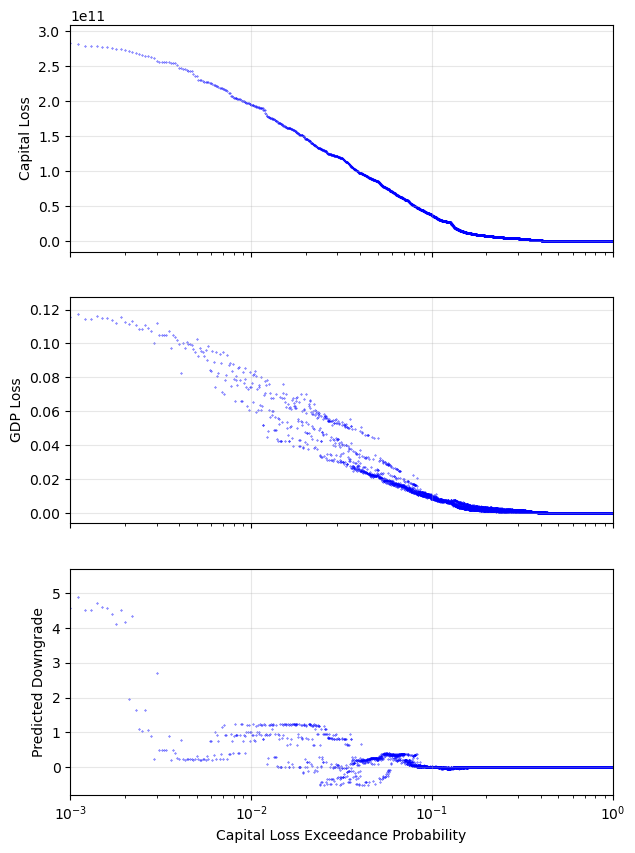

In [281]:
# Loss probability
n = len(cap_series)
x = np.arange(1, n+1) / (n+1) # Exceedance probability
fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(7,10),
    sharex=True
)

axes[0].scatter(x, baseline_cap_series, s=0.1, color='blue', label='Baseline')
# axes[0].scatter(x, future_cap_series, s=0.1, color='red', label='Future')
# axes[0].scatter(x, adapted_cap_series, s=0.1, color='green', label='Adapted')
axes[0].set_ylabel("Capital Loss")
axes[0].set_xscale("log")


axes[1].scatter(x, baseline_gdp_series, s=0.1, color='blue', label='Baseline')
# axes[1].scatter(x, future_gdp_series, s=0.1, color='red', label='Future')
# axes[1].scatter(x, adapted_gdp_series, s=0.1, color='green', label='Adapted')
axes[1].set_ylabel("GDP Loss")

axes[2].scatter(x, baseline_rat_series, s=0.1, color='blue', label='Baseline')
# axes[2].scatter(x, future_rat_series, s=0.1, color='red', label='Future')
# axes[2].scatter(x, adapted_rat_series, s=0.1, color='green', label='adapted')
axes[2].set_ylabel("Predicted Downgrade")
axes[2].set_xlabel("Capital Loss Exceedance Probability")


for ax in axes:
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0.001, 1)

# plt.legend()

plt.show()

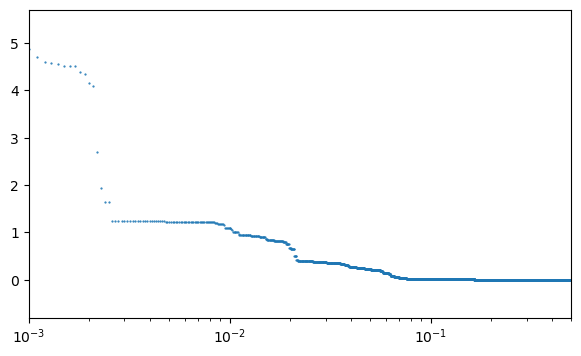

In [203]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.scatter(x, baseline_rat_series_sorted, s=0.3)
# ax.set_xscale("log")
ax.set_xlim(0.001, 0.5)
plt.show()

In [233]:
proba = baseline_df.copy()
proba = proba[['year_index', 'predicted_rating', 'p_1', 'p_2', 'p_3', 'p_4', 'p_5', 'p_6', 'p_7', 'p_8', 'p_9', 'p_10',
              'p_11', 'p_12', 'p_13', 'p_14', 'p_15', 'p_16', 'p_17', 'p_18', 'p_19', 'p_20']]
# Extract probabilities and sort in same order (as capital stock)
p_cols = [c for c in proba.columns if c.startswith("p_")]
P = proba[p_cols].to_numpy()
levels = np.arange(1, P.shape[1] + 1)

In [234]:
r0 = 12.4
ks = [1, 2, 3, 4] # downgrade probabilities
downgrade_probs = {}
for k in ks:
    threshold = r0 - k
    if threshold < levels.min():
        downgrade_probs[k] = np.ones(n)
        continue
    mask = levels <= threshold
    downgrade_probs[k] = P[:, mask].sum(axis=1)

In [235]:
downgrade_probs

{1: array([0.2705, 0.2225, 0.2205, ..., 0.2205, 0.2235, 0.2205]),
 2: array([0.1645, 0.1065, 0.1055, ..., 0.1055, 0.109 , 0.1055]),
 3: array([0.07  , 0.048 , 0.0475, ..., 0.0475, 0.051 , 0.0475]),
 4: array([0.0545, 0.032 , 0.031 , ..., 0.031 , 0.036 , 0.031 ])}

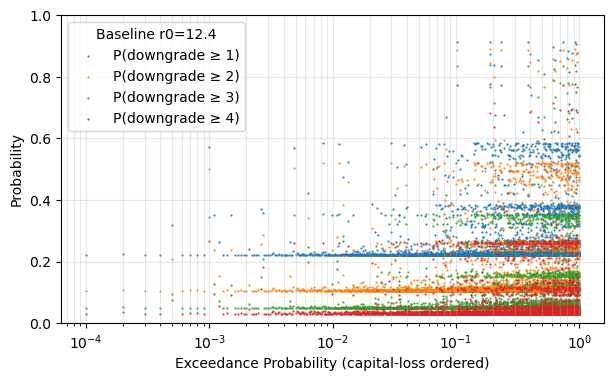

In [236]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.set_xscale("log")

for k in ks:
    downgrade_p = downgrade_probs[k][::-1]
    ax.scatter(x, downgrade_p, label=f"P(downgrade ≥ {k})", s=0.3)

ax.set_xlabel("Exceedance Probability (capital-loss ordered)")
ax.set_ylabel("Probability")
ax.set_ylim(0, 1)
ax.grid(True, which="both", alpha=0.3)
ax.legend(title=f"Baseline r0={r0}")
plt.show()

In [237]:
proba

,year_index,predicted_rating,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,...,p_11,p_12,p_13,p_14,p_15,p_16,p_17,p_18,p_19,p_20
610000,0,12.3880,0.0,0.0,0.0,0.000,0.0155,0.0150,0.0135,0.0105,...,0.1060,0.1170,0.4580,0.1060,0.001,0.0090,0.0355,0.0015,0.0005,0.0010
610061,1,12.4205,0.0,0.0,0.0,0.000,0.0060,0.0085,0.0100,0.0075,...,0.1160,0.0995,0.5385,0.1045,0.001,0.0075,0.0240,0.0015,0.0005,0.0005
610122,2,12.4200,0.0,0.0,0.0,0.001,0.0050,0.0085,0.0095,0.0070,...,0.1150,0.0985,0.5415,0.1045,0.001,0.0075,0.0240,0.0015,0.0005,0.0005
610183,3,12.4175,0.0,0.0,0.0,0.000,0.0065,0.0090,0.0100,0.0075,...,0.1155,0.0990,0.5385,0.1045,0.001,0.0075,0.0245,0.0015,0.0005,0.0005
610244,4,12.4200,0.0,0.0,0.0,0.001,0.0050,0.0085,0.0095,0.0070,...,0.1150,0.0985,0.5415,0.1045,0.001,0.0075,0.0240,0.0015,0.0005,0.0005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219695,9995,12.2840,0.0,0.0,0.0,0.000,0.0225,0.0220,0.0160,0.0135,...,0.1075,0.1355,0.3795,0.1145,0.001,0.0105,0.0390,0.0020,0.0005,0.0005
1219756,9996,12.4200,0.0,0.0,0.0,0.001,0.0050,0.0085,0.0095,0.0070,...,0.1150,0.0985,0.5415,0.1045,0.001,0.0075,0.0240,0.0015,0.0005,0.0005
1219817,9997,12.4200,0.0,0.0,0.0,0.001,0.0050,0.0085,0.0095,0.0070,...,0.1150,0.0985,0.5415,0.1045,0.001,0.0075,0.0240,0.0015,0.0005,0.0005
1219878,9998,12.4165,0.0,0.0,0.0,0.000,0.0065,0.0100,0.0110,0.0085,...,0.1145,0.0995,0.5355,0.1055,0.001,0.0075,0.0245,0.0015,0.0005,0.0010


In [239]:
# Add total cap damage column
proba["hi_inv"] = proba[["p_20", "p_19", "p_18", "p_17", "p_16"]].sum(axis=1)
proba["lo_inv"] = proba[["p_15", "p_14", "p_13", "p_12", "p_11"]].sum(axis=1)
proba["hi_spc"] = proba[["p_10", "p_9", "p_8", "p_7", "p_6"]].sum(axis=1)
proba["lo_spc"] = proba[["p_5", "p_4", "p_3", "p_2", "p_1"]].sum(axis=1)

In [270]:
proba_sorted = proba.sort_values(by="predicted_rating", ascending=False).reset_index(drop=True)
categories = {
    'Low Speculative (1-5)': proba_sorted["lo_spc"].to_numpy(),
    'High Speculative (6-10)': proba_sorted["hi_spc"].to_numpy(),
    'Low Investment Grade (11-15)': proba_sorted["lo_inv"].to_numpy(),
    'High Investment Grade (16-20)': proba_sorted["hi_inv"].to_numpy()
}

In [274]:
bottom = np.zeros(len(proba_sorted))
colors_stack = ['#E57373', '#2E7D32', '#FFB74D',  '#81C784']

In [275]:
proba_sorted

,year_index,predicted_rating,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,...,p_15,p_16,p_17,p_18,p_19,p_20,hi_inv,lo_inv,hi_spc,lo_spc
0,8687,12.9250,0.0000,0.000,0.000,0.0000,0.0485,0.0175,0.0260,0.0525,...,0.0035,0.0185,0.0250,0.0005,0.0000,0.0000,0.0440,0.7050,0.2025,0.0485
1,1158,12.9250,0.0000,0.000,0.000,0.0000,0.0485,0.0175,0.0260,0.0530,...,0.0035,0.0180,0.0250,0.0005,0.0000,0.0000,0.0435,0.7055,0.2025,0.0485
2,4925,12.9250,0.0000,0.000,0.000,0.0000,0.0485,0.0180,0.0260,0.0530,...,0.0035,0.0180,0.0250,0.0005,0.0000,0.0000,0.0435,0.7050,0.2030,0.0485
3,406,12.9250,0.0000,0.000,0.000,0.0000,0.0485,0.0175,0.0260,0.0530,...,0.0035,0.0180,0.0250,0.0005,0.0000,0.0000,0.0435,0.7055,0.2025,0.0485
4,1637,12.9210,0.0000,0.000,0.000,0.0000,0.0445,0.0190,0.0265,0.0485,...,0.0045,0.0190,0.0255,0.0005,0.0000,0.0000,0.0450,0.7085,0.2020,0.0445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,520,7.0185,0.0465,0.000,0.001,0.0065,0.3135,0.0445,0.2090,0.1280,...,0.0070,0.0110,0.0010,0.0015,0.0025,0.0015,0.0175,0.1100,0.5050,0.3675
9996,7699,7.0105,0.0420,0.007,0.001,0.0075,0.2950,0.0470,0.2605,0.1135,...,0.0075,0.0100,0.0010,0.0010,0.0015,0.0015,0.0150,0.0990,0.5335,0.3525
9997,8977,7.0105,0.0420,0.007,0.001,0.0075,0.2950,0.0470,0.2605,0.1135,...,0.0075,0.0100,0.0010,0.0010,0.0015,0.0015,0.0150,0.0990,0.5335,0.3525
9998,2586,7.0105,0.0420,0.007,0.001,0.0075,0.2950,0.0470,0.2605,0.1135,...,0.0075,0.0100,0.0010,0.0010,0.0015,0.0015,0.0150,0.0990,0.5335,0.3525


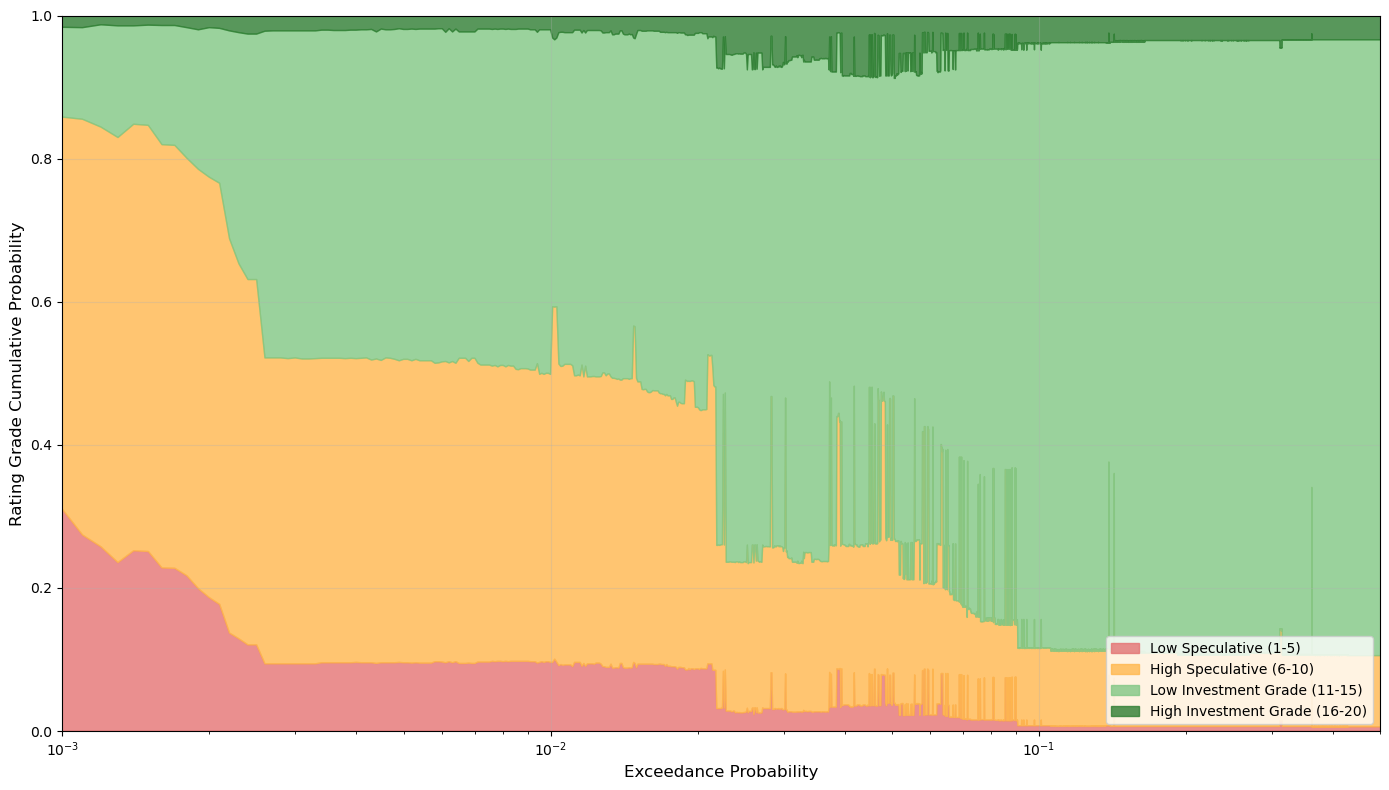

In [278]:
# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

bottom = np.zeros(len(proba_sorted))
colors_stack = ['#E57373', '#FFB74D','#81C784', '#2E7D32',   ]

for (label, data), color in zip(categories.items(), colors_stack):
    ax.fill_between(x[::-1], bottom, bottom + data, 
                    label=label, alpha=0.8, color=color)
    bottom += data

# ax.scatter(x, proba_sorted['predicted_rating'].to_numpy(), s=1)
ax.set_xlabel('Exceedance Probability', fontsize=12)
ax.set_ylabel('Rating Grade Cumulative Probability', fontsize=12)
ax.legend(loc='lower right')
ax.set_xlim([0.001, 0.5])
ax.set_xscale('log')
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [223]:
proba.to_csv("rating_probabilities.csv")

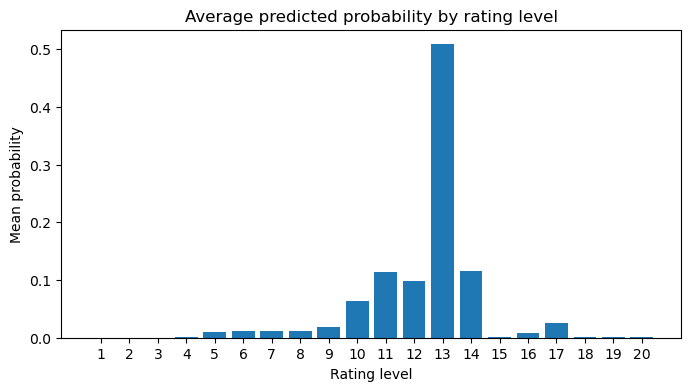

In [224]:
p_cols = [f"p_{i}" for i in range(1, 21)]
levels = np.arange(1, 21)

mean_p = proba[p_cols].mean(axis=0).to_numpy()   # length 20

plt.figure(figsize=(8,4))
plt.bar(levels, mean_p)
plt.xlabel("Rating level")
plt.ylabel("Mean probability")
plt.title("Average predicted probability by rating level")
plt.xticks(levels)
plt.show()

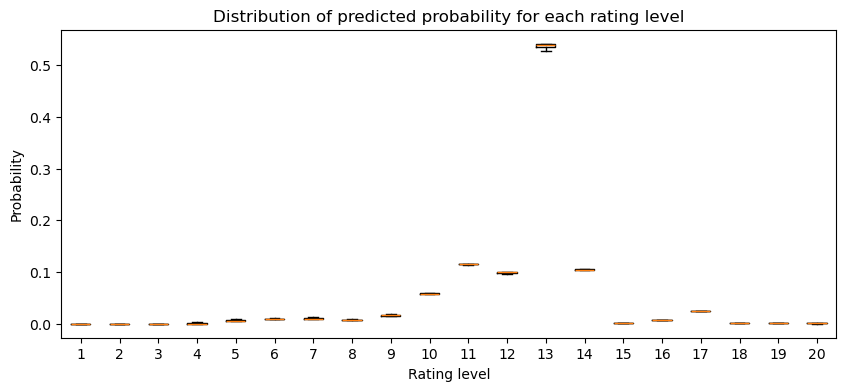

In [225]:
data = [proba[f"p_{i}"].to_numpy() for i in range(1, 21)]

plt.figure(figsize=(10,4))
plt.boxplot(data, showfliers=False)
plt.xlabel("Rating level")
plt.ylabel("Probability")
plt.title("Distribution of predicted probability for each rating level")
plt.xticks(np.arange(1, 21), np.arange(1, 21))
plt.show()

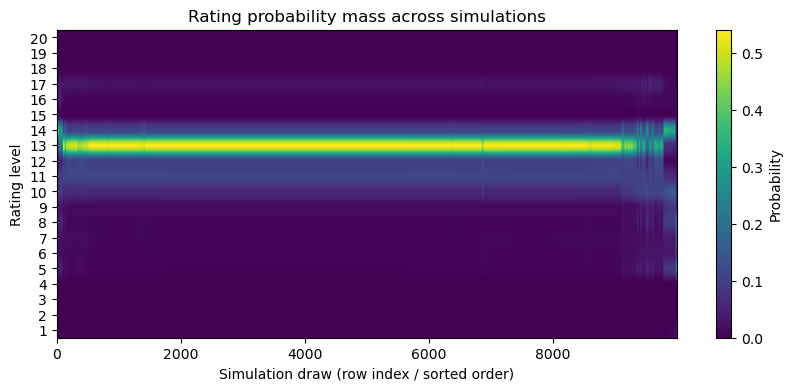

In [279]:
# Suppose you already have proba_sorted aligned & sorted by your chosen ordering
# If not sorted, just use proba as-is:
P = proba_sorted[p_cols].to_numpy()  # shape: (n_rows, 20)

Z = P.T  # (20, n_rows)

plt.figure(figsize=(10,4))
plt.imshow(Z, aspect="auto", origin="lower")
plt.xlabel("Simulation draw (row index / sorted order)")
plt.ylabel("Rating level")
plt.yticks(np.arange(0, 20), np.arange(1, 21))
plt.title("Rating probability mass across simulations")
plt.colorbar(label="Probability")
plt.show()


In [228]:
proba

,year_index,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,...,p_11,p_12,p_13,p_14,p_15,p_16,p_17,p_18,p_19,p_20
610000,0,0.0,0.0,0.0,0.000,0.0155,0.0150,0.0135,0.0105,0.0155,...,0.1060,0.1170,0.4580,0.1060,0.001,0.0090,0.0355,0.0015,0.0005,0.0010
610061,1,0.0,0.0,0.0,0.000,0.0060,0.0085,0.0100,0.0075,0.0160,...,0.1160,0.0995,0.5385,0.1045,0.001,0.0075,0.0240,0.0015,0.0005,0.0005
610122,2,0.0,0.0,0.0,0.001,0.0050,0.0085,0.0095,0.0070,0.0165,...,0.1150,0.0985,0.5415,0.1045,0.001,0.0075,0.0240,0.0015,0.0005,0.0005
610183,3,0.0,0.0,0.0,0.000,0.0065,0.0090,0.0100,0.0075,0.0160,...,0.1155,0.0990,0.5385,0.1045,0.001,0.0075,0.0245,0.0015,0.0005,0.0005
610244,4,0.0,0.0,0.0,0.001,0.0050,0.0085,0.0095,0.0070,0.0165,...,0.1150,0.0985,0.5415,0.1045,0.001,0.0075,0.0240,0.0015,0.0005,0.0005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219695,9995,0.0,0.0,0.0,0.000,0.0225,0.0220,0.0160,0.0135,0.0200,...,0.1075,0.1355,0.3795,0.1145,0.001,0.0105,0.0390,0.0020,0.0005,0.0005
1219756,9996,0.0,0.0,0.0,0.001,0.0050,0.0085,0.0095,0.0070,0.0165,...,0.1150,0.0985,0.5415,0.1045,0.001,0.0075,0.0240,0.0015,0.0005,0.0005
1219817,9997,0.0,0.0,0.0,0.001,0.0050,0.0085,0.0095,0.0070,0.0165,...,0.1150,0.0985,0.5415,0.1045,0.001,0.0075,0.0240,0.0015,0.0005,0.0005
1219878,9998,0.0,0.0,0.0,0.000,0.0065,0.0100,0.0110,0.0085,0.0150,...,0.1145,0.0995,0.5355,0.1055,0.001,0.0075,0.0245,0.0015,0.0005,0.0010


In [229]:
# Extract rating columns
rating_cols = [col for col in proba.columns if col.startswith('p_')]
rating_cols_sorted = sorted(rating_cols, key=lambda x: int(x.split('_')[1]))
ratings_df = proba[rating_cols_sorted].copy()
year_index = proba['year_index'].values

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=int64)